In [1]:
cd '/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark'

/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 135931464785787398
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 47596913408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18183475401373541581
physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:20:00.0, compute capability: 7.5"
]


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import random
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from fastmri_recon.data.sequences.senior_mc_sequences import Masked_MC_2DSequence
from fastmri_recon.models.functional_models.mcpdnet import mcpdnet

from fastmri_recon.evaluate.metrics.np_metrics import METRIC_FUNCS, Metrics
from skimage.measure import compare_psnr, compare_ssim
from fastmri_recon.evaluate.reconstruction.zero_filled_reconstruction import reco_and_gt_zfilled_from_val_file
from fastmri_recon.evaluate.reconstruction.cross_domain_reconstruction import reco_and_gt_net_from_val_file
from fastmri_recon.models.functional_models.cascading import cascade_net
from fastmri_recon.models.functional_models.kiki import kiki_net
from fastmri_recon.models.functional_models.kiki_sep import full_kiki_net
from fastmri_recon.models.functional_models.pdnet import pdnet
from fastmri_recon.models.functional_models.unet import unet
from fastmri_recon.models.utils.non_linearities import lrelu

import matplotlib.pyplot as plt

In [5]:
np.random.seed(0)

In [6]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [7]:
AF = 4

In [8]:
# paths
train_path = '/neurospin/optimed/SeniorData/Multicontrast_test'
data_gen = Masked_MC_2DSequence(
    train_path,
    af=AF,
    inner_slices=32,
    scale_factor=1e-2,
    seed=0,
    rand=True,
    val_split=1,
)
test_gen_mask = data_gen.val_sequence
n_test = 8
random.seed(0)
test_gen_mask.filenames = random.sample(test_gen_mask.filenames, n_test)


In [9]:
all_net_params = [
    {
        'name': 'mcpdnet',
        'init_function': mcpdnet,
        'run_params': {
            'n_primal': 5,
            'n_dual': 5,
            'n_iter': 12,
            'n_filters': 32,
        },
        'run_id': 'mcpdnet_af4_senior_2021_09_09_11_29_16',
    }
]

In [10]:
image_index = 4
slice_index = 15
def unpack_model(init_function=None, run_params=None, run_id=None, epoch=100, **dummy_kwargs):
    try:
        model = init_function(input_size=(None, None, None, 1), fastmri=False, **run_params)
    except:
        model = init_function(input_size=(None, None, None, 1), **run_params)
    chkpt_path = f'/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark/checkpoints_senior/{run_id}-{epoch}.hdf5'
    model.load_weights(chkpt_path)
    return model

def metrics_for_params(val_gen=None, p = 0, name=None, **net_params):
    if val_gen is None:
        val_gen = test_gen_mask
    model = unpack_model(**net_params)
    metrics = Metrics(METRIC_FUNCS)
    pred_and_gt = [
        reco_and_gt_net_from_val_file(*val_gen[i], model)
        for i in tqdm_notebook(range(len(val_gen)), desc=f'Val files for {name}')
    ]    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc=f'Stats for {name}'):
        metrics.push(images[:,p,:,:], im_recos[:,p,:,:])
    return metrics


def image_recon(val_gen=None, p = 0, **net_params):
    if val_gen is None:
        val_gen = test_gen_mask
    model = unpack_model(**net_params)
    im_recos, img_batch = reco_and_gt_net_from_val_file(*val_gen[image_index], model)
    im_recos = im_recos / 1e-2
    img_batch = img_batch / 1e-2
    
    
    im_reco = im_recos[slice_index]
    im_gt = img_batch[slice_index]
    psnr_im = compare_psnr(im_gt[p], im_reco[p], data_range=im_gt[p].max() - im_gt[p].min())
    ssim_im = compare_ssim(im_gt[p], im_reco[p], data_range=im_gt[p].max() - im_gt[p].min())
    im_res = np.abs(im_gt[p] - im_reco[p])
    fig, axs = plt.subplots(1, 3, figsize=(27, 18))
    axs[0].imshow(np.abs(im_gt[p]), cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('actual T2 TSE image', fontsize = 30)
    axs[1].imshow(np.abs(im_reco[p]), cmap='gray')
    axs[1].set_title('recon ' +net_params['name']+ '\npsnr = ' +str(str(round(float(psnr_im), 2)))+ ', ssim = ' +str(str(round(float(ssim_im), 4))), fontsize = 30)
    axs[1].axis('off')
    axs[2].imshow(np.abs(im_res), cmap='gray')
    axs[2].set_title('residual ' +net_params['name'], fontsize = 30)  
    axs[2].axis('off')
    plt.show()
    return (im_recos, img_batch)


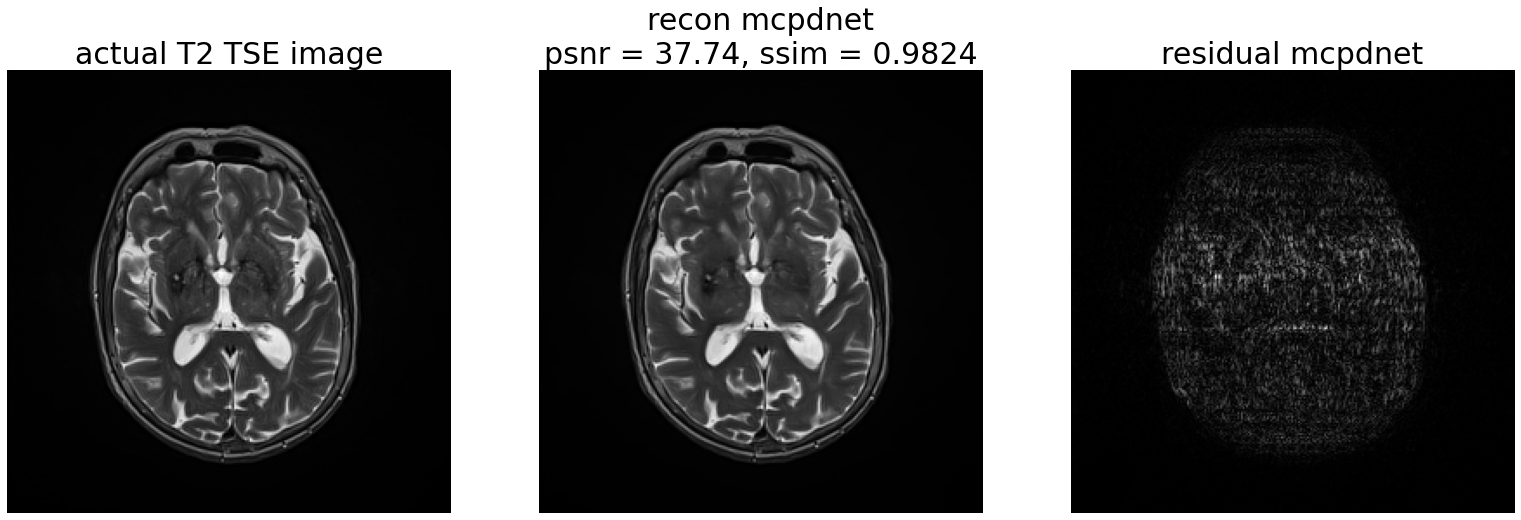

In [11]:
%matplotlib inline
# p = 0 : T2 GRE , p = 1: FLAIR, p= 2: T2 TSE

for net_params in all_net_params:
    im_recos, img_batch = image_recon(p = 2, **net_params)
  

In [12]:
%%time
# p = 0 : T2 GRE , p = 1: FLAIR, p= 2: T2 TSE
metrics = []
for net_params in all_net_params:
    metrics.append((net_params['name'], metrics_for_params(p = 2, **net_params)))



CPU times: user 28.1 s, sys: 9.19 s, total: 37.3 s
Wall time: 50 s


In [13]:
metrics

[('mcpdnet', PSNR = 39.83 +/- 1.755 SSIM = 0.984 +/- 0.004552)]

In [14]:
metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())

In [15]:
def n_model_params_for_params(reco_function=None, val_gen=None, name=None, **net_params):
    model = unpack_model(**net_params)
    n_params = model.count_params()
    return n_params

In [16]:
%%time
n_params = {}
for net_params in all_net_params:
    n_params[net_params['name']] =  n_model_params_for_params(**net_params)


CPU times: user 2.71 s, sys: 54.3 ms, total: 2.76 s
Wall time: 2.78 s


In [17]:
def runtime_for_params(val_gen=None, name=None, **net_params):
    if val_gen is None:
        val_gen = test_gen_mask
    model = unpack_model(**net_params)
    data = val_gen[0]
    start = time.time()
    reco_and_gt_net_from_val_file(*data, model)
    end = time.time()
    return end - start

def runtime_zfilled():
    data = test_gen_mask[0]
    start = time.time()
    reco_and_gt_zfilled_from_val_file(*data, crop=False)
    end = time.time()
    return end - start

In [18]:
%%time
runtimes = {}
for net_params in tqdm_notebook(all_net_params):
    runtimes[net_params['name']] =  runtime_for_params(**net_params)
    


CPU times: user 10.5 s, sys: 5.16 s, total: 15.7 s
Wall time: 19.4 s


In [19]:
metrics_table = pd.DataFrame(
    index=[name for name, _ in metrics], 
    columns=['PSNR-mean (std) (dB)', 'SSIM-mean (std)', '# params', 'Runtime (s)'],
)
for name, m in metrics:
    metrics_table.loc[name, 'PSNR-mean (std) (dB)'] = "{mean:.4} ({std:.4})".format(
        mean=m.metrics['PSNR'].mean(), 
        std=m.metrics['PSNR'].stddev(),
    )
    metrics_table.loc[name, 'SSIM-mean (std)'] = "{mean:.4} ({std:.4})".format(
        mean=m.metrics['SSIM'].mean(), 
        std=m.metrics['SSIM'].stddev(),
    )
    metrics_table.loc[name, '# params'] = "{}".format(
        n_params[name], 
     )
    metrics_table.loc[name, 'Runtime (s)'] = "{runtime:.4}".format(
        runtime=runtimes[name], 
    )

In [20]:
metrics_table

,PSNR-mean (std) (dB),SSIM-mean (std),# params,Runtime (s)
mcpdnet,39.83 (1.755),0.984 (0.004552),381936,15.81
